In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import keras
import tensorflow as tf
import cv2
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

Generate Data From chest_xray Folder:

In [3]:
labels = ['NORMAL', 'PNEUMONIA']  # NORMAL = 0 , PNEUMONIA = 1
all_classes_labels = ['NORMAL', 'BACTERIA', 'VIRUS']  # NORMAL = 0 , BACTERIA = 1, VIRUS = 2
IMG_SIZE = 150


#Concatenate all images in the different folders to three lists: normal, bacterial and virus

def get_training_data(data_dir):
    normal_data = []
    bacterial_data = []
    virus_data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                if label == 'NORMAL':
                  class_num = all_classes_labels.index('NORMAL')
                  normal_data.append([resized_arr, class_num])
                elif label == 'PNEUMONIA':
                  if "bacteria" in str(img):
                    class_num = all_classes_labels.index('BACTERIA')
                    bacterial_data.append([resized_arr, class_num])
                  elif "virus" in str(img):
                    class_num = all_classes_labels.index('VIRUS')
                    virus_data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


# Includes both normal and pneumonia cases.
normal_data, bacterial_data, virus_data = get_training_data('/content/drive/MyDrive/Deep Learning Project/chest_xray/')  # list of [image, label]


<ipython-input-3-008a6b74dcd1>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(normal_data), np.array(bacterial_data), np.array(virus_data)


Generate Train, Validation and Test Sets:

In [4]:
SEED = 42
# Separate data and labels for each class
X_normal = [data[0] for data in normal_data]
y_normal = [data[1] for data in normal_data]

X_bacterial = [data[0] for data in bacterial_data]
y_bacterial = [data[1] for data in bacterial_data]

X_virus = [data[0] for data in virus_data]
y_virus = [data[1] for data in virus_data]

# Perform train-test split for each class separately
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.15, random_state=SEED)
X_bacterial_train, X_bacterial_test, y_bacterial_train, y_bacterial_test = train_test_split(X_bacterial, y_bacterial, test_size=0.05, random_state=SEED)
X_virus_train, X_virus_test, y_virus_train, y_virus_test = train_test_split(X_virus, y_virus, test_size=0.075, random_state=SEED)

# Split the training sets into training and validation sets for each class
X_normal_train, X_normal_val, y_normal_train, y_normal_val = train_test_split(X_normal_train, y_normal_train, test_size=0.038, random_state=SEED)
X_bacterial_train, X_bacterial_val, y_bacterial_train, y_bacterial_val = train_test_split(X_bacterial_train, y_bacterial_train, test_size=0.0095, random_state=SEED)
X_virus_train, X_virus_val, y_virus_train, y_virus_val = train_test_split(X_virus_train, y_virus_train, test_size=0.019, random_state=SEED)

# Merge the data and labels for all classes
X_train = np.concatenate((X_normal_train, X_bacterial_train, X_virus_train), axis=0)
y_train = np.concatenate((y_normal_train, y_bacterial_train, y_virus_train), axis=0)
X_val = np.concatenate((X_normal_val, X_bacterial_val, X_virus_val), axis=0)
y_val = np.concatenate((y_normal_val, y_bacterial_val, y_virus_val), axis=0)
X_test = np.concatenate((X_normal_test, X_bacterial_test, X_virus_test), axis=0)
y_test = np.concatenate((y_normal_test, y_bacterial_test, y_virus_test), axis=0)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape data for deep learning
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Rest of the code for data augmentation and model training
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(X_train)


Building CNN Network:

In [5]:
def create_model():
    kernelSize = (3,3)
    poolSize = (2,2)
    strideSize = (2,2)
    # If you are creating many models in a loop, this global state will consume
    # an increasing amount of memory over time, and you may want to clear it.
    # Calling clear_session() releases the global state: this helps avoid clutter
    # from old models and layers, especially when memory is limited.
    keras.backend.clear_session()

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=kernelSize, padding='same',
                    activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=kernelSize, padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=poolSize,strides=strideSize))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))

    return model

Try Different Epochs and Learning Rates
* Compile and Train the Model for each Epoch and Learning Rate
* Plot Graphs of the Training and Validation Accuracy and Loss vs Epochs

Epoch 1/10
329/329 [==============================] - 25s 41ms/step - loss: 1.1441 - accuracy: 0.6619 - val_loss: 1.2787 - val_accuracy: 0.2952
Epoch 2/10
329/329 [==============================] - 12s 37ms/step - loss: 0.6107 - accuracy: 0.7474 - val_loss: 0.9605 - val_accuracy: 0.7429
Epoch 3/10
329/329 [==============================] - 12s 37ms/step - loss: 0.5377 - accuracy: 0.7769 - val_loss: 0.6253 - val_accuracy: 0.8095
Epoch 4/10
329/329 [==============================] - 12s 37ms/step - loss: 0.5115 - accuracy: 0.7900 - val_loss: 0.6610 - val_accuracy: 0.8381
Epoch 5/10
329/329 [==============================] - 12s 38ms/step - loss: 0.4956 - accuracy: 0.8060 - val_loss: 0.5779 - val_accuracy: 0.8095
Epoch 6/10
329/329 [==============================] - 13s 38ms/step - loss: 0.4742 - accuracy: 0.8077 - val_loss: 0.5204 - val_accuracy: 0.8190
Epoch 7/10
329/329 [==============================] - 13s 38ms/step - loss: 0.4480 - accuracy: 0.8166 - val_loss: 0.6219 - val_accuracy:

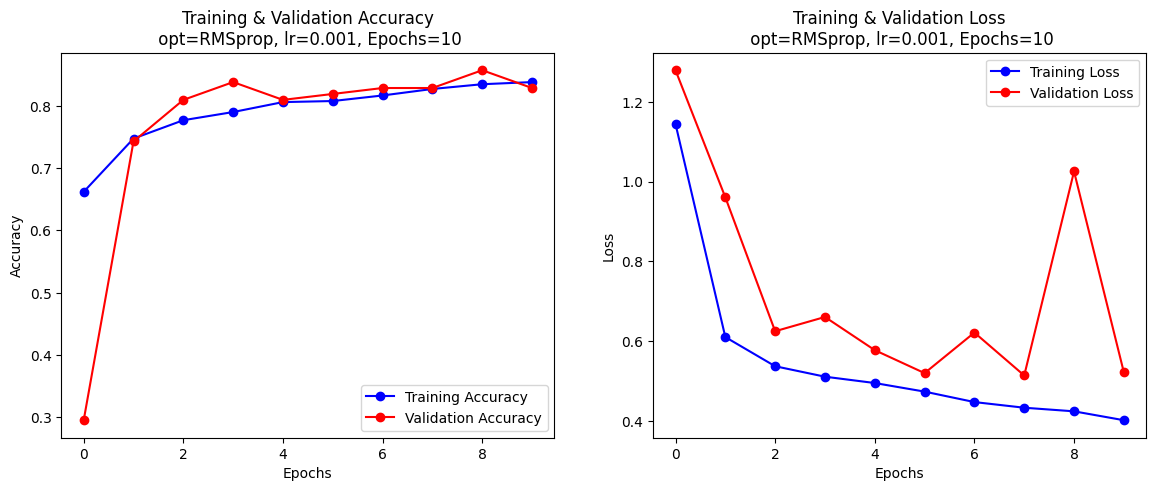

Epoch 1/10
329/329 [==============================] - 15s 39ms/step - loss: 0.8481 - accuracy: 0.6857 - val_loss: 1.5405 - val_accuracy: 0.2476
Epoch 2/10
329/329 [==============================] - 12s 38ms/step - loss: 0.5695 - accuracy: 0.7714 - val_loss: 0.7827 - val_accuracy: 0.7048
Epoch 3/10
329/329 [==============================] - 13s 38ms/step - loss: 0.5139 - accuracy: 0.7875 - val_loss: 0.7461 - val_accuracy: 0.8095
Epoch 4/10
329/329 [==============================] - 12s 38ms/step - loss: 0.4966 - accuracy: 0.8033 - val_loss: 0.5429 - val_accuracy: 0.8095
Epoch 5/10
329/329 [==============================] - 12s 38ms/step - loss: 0.4599 - accuracy: 0.8138 - val_loss: 0.5698 - val_accuracy: 0.8095
Epoch 6/10
329/329 [==============================] - 12s 38ms/step - loss: 0.4448 - accuracy: 0.8216 - val_loss: 0.7522 - val_accuracy: 0.8190
Epoch 7/10
329/329 [==============================] - 12s 38ms/step - loss: 0.4128 - accuracy: 0.8328 - val_loss: 0.5614 - val_accuracy:

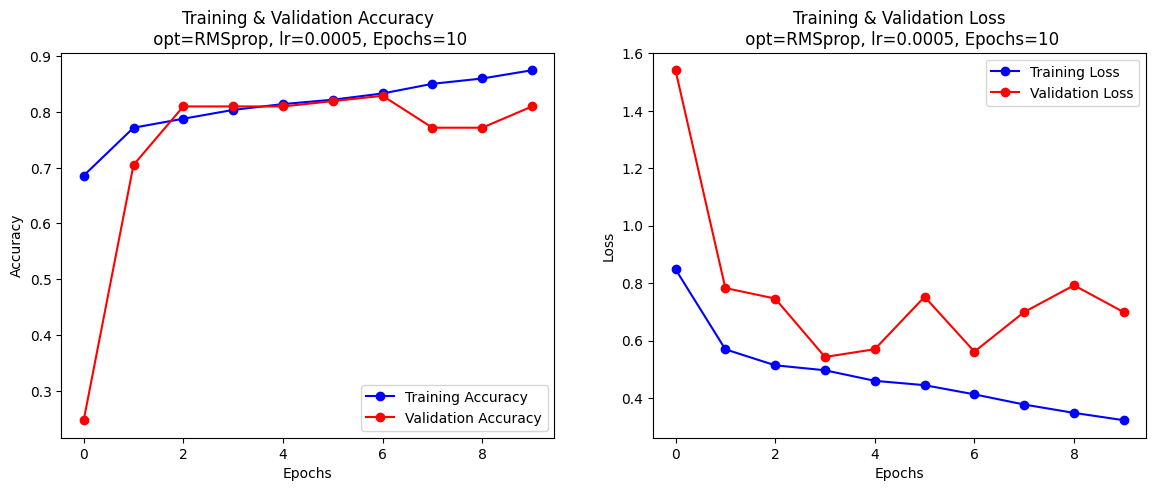

Epoch 1/10
329/329 [==============================] - 14s 39ms/step - loss: 0.6231 - accuracy: 0.7305 - val_loss: 2.9807 - val_accuracy: 0.2571
Epoch 2/10
329/329 [==============================] - 13s 39ms/step - loss: 0.5136 - accuracy: 0.7794 - val_loss: 2.4436 - val_accuracy: 0.2762
Epoch 3/10
329/329 [==============================] - 13s 39ms/step - loss: 0.4705 - accuracy: 0.8054 - val_loss: 0.6185 - val_accuracy: 0.8000
Epoch 4/10
329/329 [==============================] - 13s 38ms/step - loss: 0.4306 - accuracy: 0.8214 - val_loss: 0.5837 - val_accuracy: 0.8000
Epoch 5/10
329/329 [==============================] - 12s 38ms/step - loss: 0.3961 - accuracy: 0.8341 - val_loss: 0.5808 - val_accuracy: 0.8000
Epoch 6/10
329/329 [==============================] - 12s 38ms/step - loss: 0.3566 - accuracy: 0.8483 - val_loss: 0.5310 - val_accuracy: 0.8381
Epoch 7/10
329/329 [==============================] - 13s 38ms/step - loss: 0.3166 - accuracy: 0.8649 - val_loss: 0.5216 - val_accuracy:

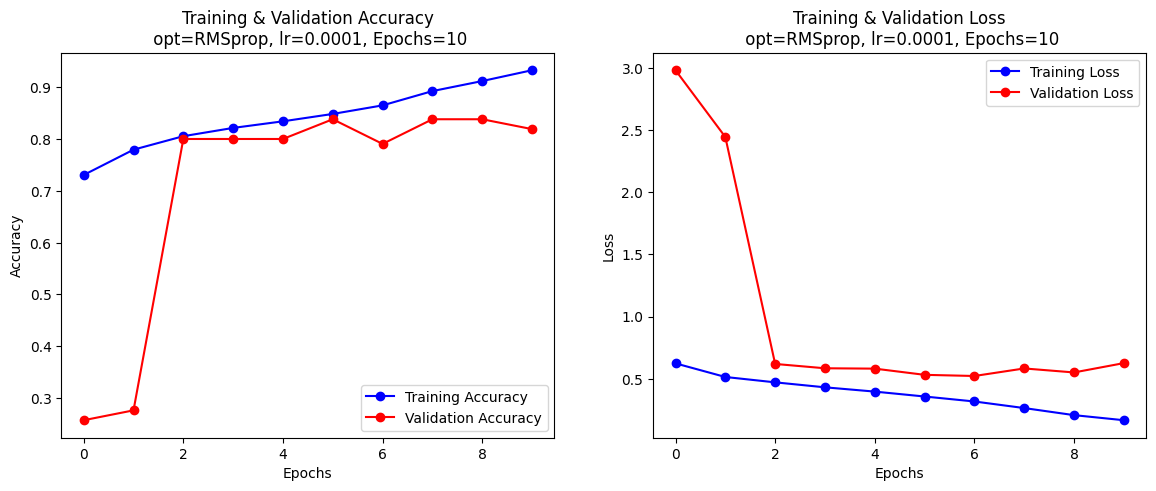

Epoch 1/20
329/329 [==============================] - 15s 39ms/step - loss: 1.0432 - accuracy: 0.6577 - val_loss: 1.5249 - val_accuracy: 0.3905
Epoch 2/20
329/329 [==============================] - 13s 39ms/step - loss: 0.5614 - accuracy: 0.7659 - val_loss: 0.5317 - val_accuracy: 0.8000
Epoch 3/20
329/329 [==============================] - 13s 39ms/step - loss: 0.5309 - accuracy: 0.7845 - val_loss: 0.4479 - val_accuracy: 0.8571
Epoch 4/20
329/329 [==============================] - 13s 39ms/step - loss: 0.5045 - accuracy: 0.7972 - val_loss: 0.6791 - val_accuracy: 0.7714
Epoch 5/20
329/329 [==============================] - 13s 38ms/step - loss: 0.4701 - accuracy: 0.8092 - val_loss: 0.7679 - val_accuracy: 0.8095
Epoch 6/20
329/329 [==============================] - 13s 38ms/step - loss: 0.4476 - accuracy: 0.8153 - val_loss: 0.8737 - val_accuracy: 0.7524
Epoch 7/20
329/329 [==============================] - 13s 38ms/step - loss: 0.4346 - accuracy: 0.8246 - val_loss: 1.5102 - val_accuracy:

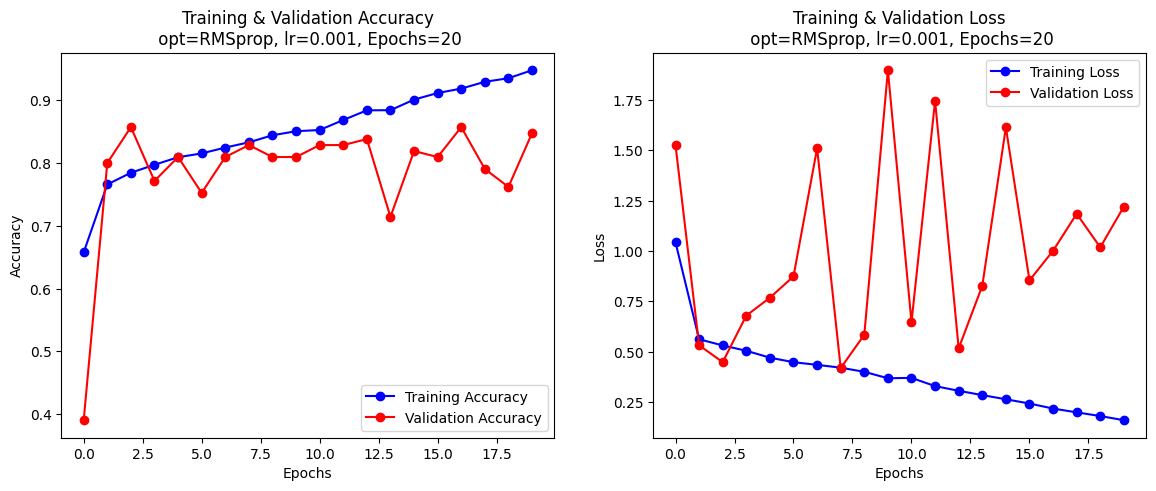

Epoch 1/20
329/329 [==============================] - 14s 39ms/step - loss: 0.7812 - accuracy: 0.7121 - val_loss: 3.2932 - val_accuracy: 0.2476
Epoch 2/20
329/329 [==============================] - 13s 38ms/step - loss: 0.5554 - accuracy: 0.7718 - val_loss: 0.8547 - val_accuracy: 0.7238
Epoch 3/20
329/329 [==============================] - 13s 39ms/step - loss: 0.5176 - accuracy: 0.7911 - val_loss: 0.4523 - val_accuracy: 0.8095
Epoch 4/20
329/329 [==============================] - 13s 38ms/step - loss: 0.4805 - accuracy: 0.8037 - val_loss: 0.4250 - val_accuracy: 0.8476
Epoch 5/20
329/329 [==============================] - 12s 38ms/step - loss: 0.4408 - accuracy: 0.8200 - val_loss: 0.8318 - val_accuracy: 0.8381
Epoch 6/20
329/329 [==============================] - 13s 38ms/step - loss: 0.4259 - accuracy: 0.8324 - val_loss: 0.5236 - val_accuracy: 0.8571
Epoch 7/20
329/329 [==============================] - 12s 38ms/step - loss: 0.4066 - accuracy: 0.8371 - val_loss: 0.4628 - val_accuracy:

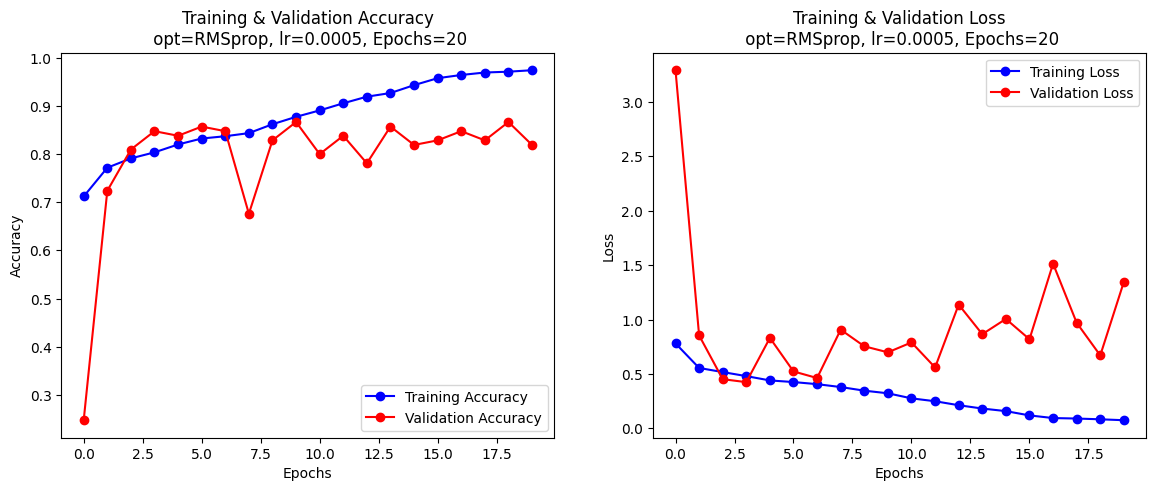

Epoch 1/20
329/329 [==============================] - 15s 40ms/step - loss: 0.6516 - accuracy: 0.7343 - val_loss: 3.9881 - val_accuracy: 0.2476
Epoch 2/20
329/329 [==============================] - 12s 37ms/step - loss: 0.5289 - accuracy: 0.7761 - val_loss: 1.8991 - val_accuracy: 0.4000
Epoch 3/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4840 - accuracy: 0.7948 - val_loss: 0.6069 - val_accuracy: 0.7714
Epoch 4/20
329/329 [==============================] - 12s 38ms/step - loss: 0.4642 - accuracy: 0.8018 - val_loss: 0.6111 - val_accuracy: 0.7619
Epoch 5/20
329/329 [==============================] - 12s 37ms/step - loss: 0.4215 - accuracy: 0.8214 - val_loss: 0.6278 - val_accuracy: 0.7714
Epoch 6/20
329/329 [==============================] - 12s 38ms/step - loss: 0.3827 - accuracy: 0.8394 - val_loss: 0.5426 - val_accuracy: 0.7905
Epoch 7/20
329/329 [==============================] - 12s 37ms/step - loss: 0.3450 - accuracy: 0.8558 - val_loss: 0.4823 - val_accuracy:

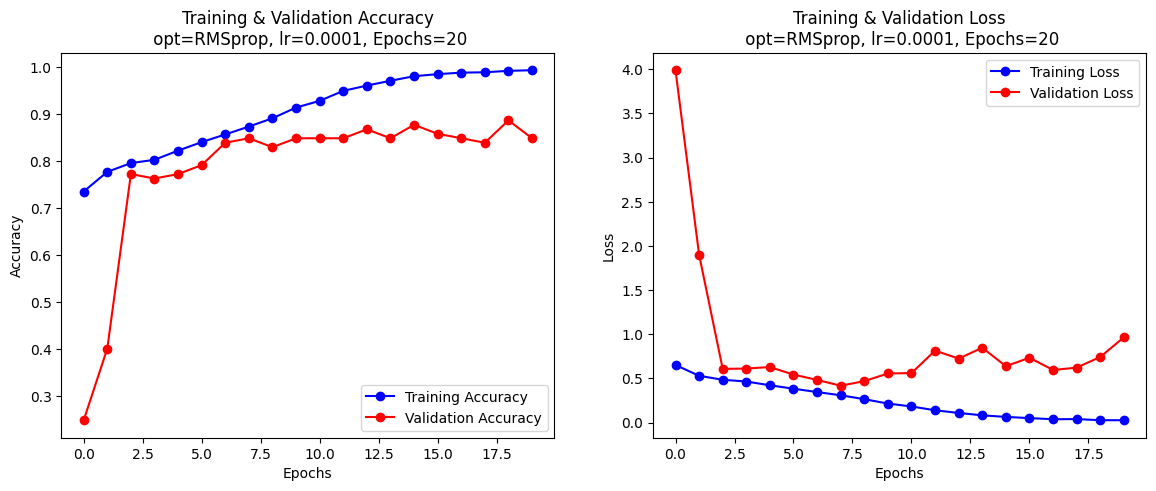

Epoch 1/40
329/329 [==============================] - 15s 39ms/step - loss: 1.0899 - accuracy: 0.6650 - val_loss: 1.0501 - val_accuracy: 0.4952
Epoch 2/40
329/329 [==============================] - 12s 38ms/step - loss: 0.5944 - accuracy: 0.7569 - val_loss: 0.6519 - val_accuracy: 0.7524
Epoch 3/40
329/329 [==============================] - 13s 38ms/step - loss: 0.5266 - accuracy: 0.7896 - val_loss: 0.8756 - val_accuracy: 0.7048
Epoch 4/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4903 - accuracy: 0.7991 - val_loss: 1.2354 - val_accuracy: 0.7619
Epoch 5/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4747 - accuracy: 0.8149 - val_loss: 0.6114 - val_accuracy: 0.8381
Epoch 6/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4611 - accuracy: 0.8183 - val_loss: 0.5064 - val_accuracy: 0.8190
Epoch 7/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4416 - accuracy: 0.8238 - val_loss: 3.2464 - val_accuracy:

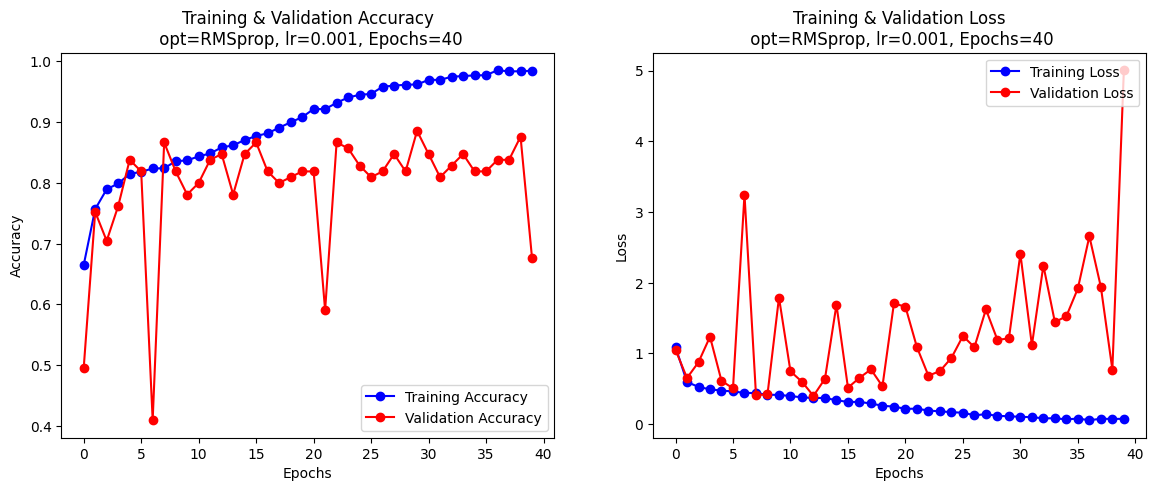

Epoch 1/40
329/329 [==============================] - 15s 40ms/step - loss: 0.8750 - accuracy: 0.6880 - val_loss: 2.8154 - val_accuracy: 0.2857
Epoch 2/40
329/329 [==============================] - 13s 39ms/step - loss: 0.5970 - accuracy: 0.7579 - val_loss: 0.8389 - val_accuracy: 0.6476
Epoch 3/40
329/329 [==============================] - 13s 39ms/step - loss: 0.5410 - accuracy: 0.7801 - val_loss: 0.7548 - val_accuracy: 0.8095
Epoch 4/40
329/329 [==============================] - 13s 39ms/step - loss: 0.4937 - accuracy: 0.8018 - val_loss: 0.9480 - val_accuracy: 0.7524
Epoch 5/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4854 - accuracy: 0.8043 - val_loss: 0.4682 - val_accuracy: 0.8667
Epoch 6/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4431 - accuracy: 0.8212 - val_loss: 0.6409 - val_accuracy: 0.7714
Epoch 7/40
329/329 [==============================] - 13s 39ms/step - loss: 0.4357 - accuracy: 0.8242 - val_loss: 1.4033 - val_accuracy:

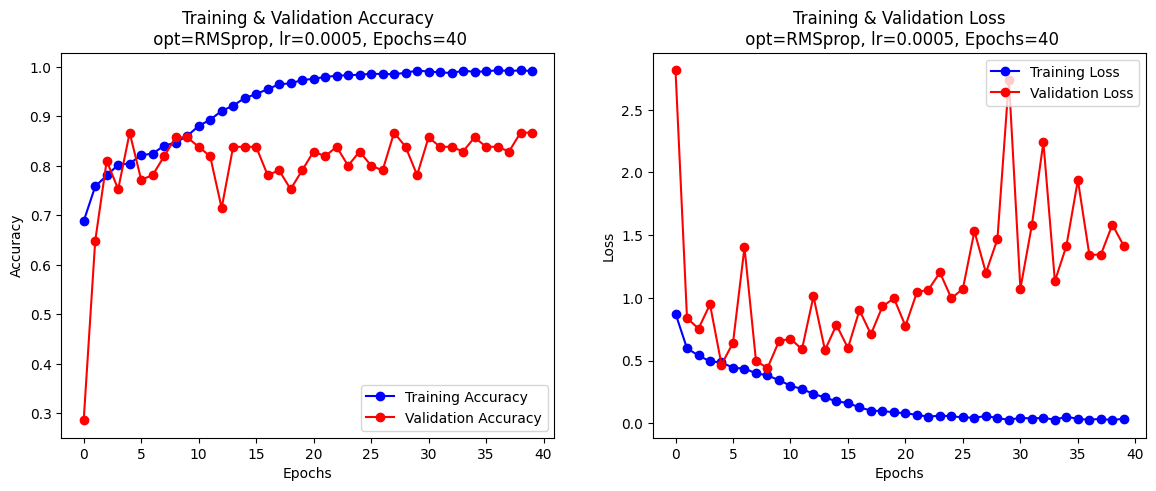

Epoch 1/40
329/329 [==============================] - 15s 39ms/step - loss: 0.6429 - accuracy: 0.7330 - val_loss: 4.6014 - val_accuracy: 0.2476
Epoch 2/40
329/329 [==============================] - 13s 39ms/step - loss: 0.5220 - accuracy: 0.7820 - val_loss: 1.4824 - val_accuracy: 0.4762
Epoch 3/40
329/329 [==============================] - 13s 39ms/step - loss: 0.4665 - accuracy: 0.8039 - val_loss: 0.5501 - val_accuracy: 0.7524
Epoch 4/40
329/329 [==============================] - 13s 38ms/step - loss: 0.4234 - accuracy: 0.8191 - val_loss: 0.5133 - val_accuracy: 0.8286
Epoch 5/40
329/329 [==============================] - 13s 38ms/step - loss: 0.3915 - accuracy: 0.8409 - val_loss: 0.5467 - val_accuracy: 0.7905
Epoch 6/40
329/329 [==============================] - 13s 38ms/step - loss: 0.3442 - accuracy: 0.8565 - val_loss: 0.6789 - val_accuracy: 0.7524
Epoch 7/40
329/329 [==============================] - 13s 38ms/step - loss: 0.3043 - accuracy: 0.8742 - val_loss: 0.6718 - val_accuracy:

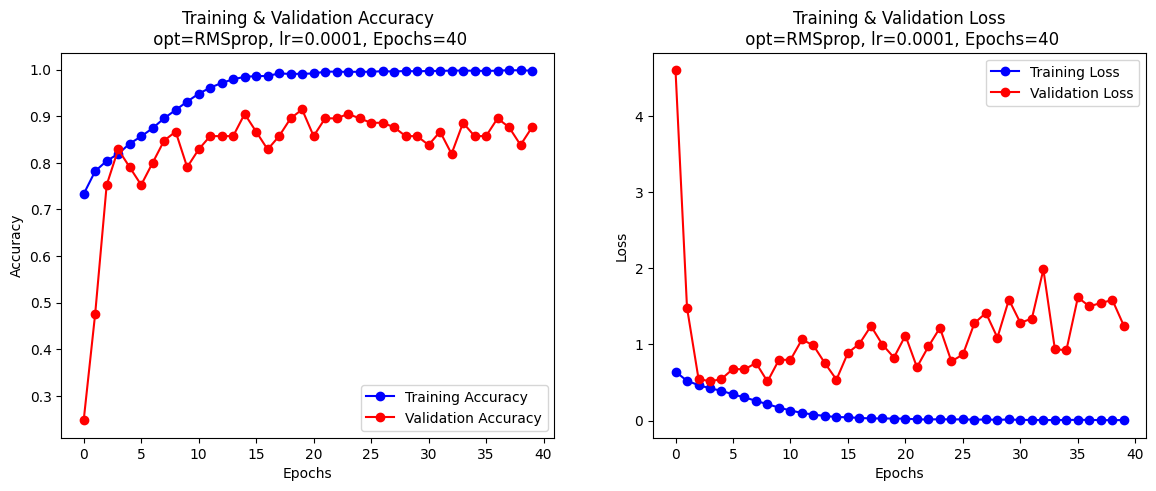

In [6]:
Epochs = [10, 20, 40]
learning_rates= [0.001, 0.0005, 0.0001]
opt = RMSprop

lr_epoch_test_acc = {}
lr_epoch_test_loss = {}
for Epoch in Epochs:
  for lr in learning_rates:
    model = create_model()
    model.compile(optimizer=opt(learning_rate=lr),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=16,
                        epochs=Epoch, validation_data=(X_val, y_val))

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    lr_epoch_tuple = (Epoch, lr)
    lr_epoch_test_acc[lr_epoch_tuple] = test_accuracy
    lr_epoch_test_loss[lr_epoch_tuple] = test_loss
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    ## Create a figure and subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot the training and validation accuracy
    axs[0].plot(train_acc, 'bo-', label='Training Accuracy')
    axs[0].plot(val_acc, 'ro-', label='Validation Accuracy')
    axs[0].set_title(f'Training & Validation Accuracy\n opt={opt.__name__}, lr={lr}, Epochs={Epoch}')
    # axs[0].title.set_size(10) # if title is too big, change the size here
    axs[0].legend(loc='lower right')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")

    # Plot the training and validation loss
    axs[1].plot(train_loss, 'bo-', label='Training Loss')
    axs[1].plot(val_loss, 'ro-', label='Validation Loss')
    axs[1].set_title(f'Training & Validation Loss\n opt={opt.__name__}, lr={lr}, Epochs={Epoch}')
    # axs[1].title.set_size(10) # if title is too big, change the size here
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.2)

    plt.show()


Print the Loss & Accuracy Dictionaries

In [7]:
print(f"Test Accuracy and Loss Results with Optimizer: {opt.__name__}")
print()
print()
def print_results_dict(Accuracy, Loss):
    print("Print Accuracy Results")
    for key, val in Accuracy.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Accuracy = {val:.3f}")
    print()
    print()
    print("Print Loss Results")
    for key, val in Loss.items():
        epochs, lr = key
        print(f"Epochs Number = {epochs}, Learning Rate = {lr}, Loss = {val:.3f}")


print_results_dict(lr_epoch_test_acc, lr_epoch_test_loss)

Test Accuracy and Loss Results with Optimizer: RMSprop


Print Accuracy Results
Epochs Number = 10, Learning Rate = 0.001, Accuracy = 0.814
Epochs Number = 10, Learning Rate = 0.0005, Accuracy = 0.838
Epochs Number = 10, Learning Rate = 0.0001, Accuracy = 0.826
Epochs Number = 20, Learning Rate = 0.001, Accuracy = 0.820
Epochs Number = 20, Learning Rate = 0.0005, Accuracy = 0.775
Epochs Number = 20, Learning Rate = 0.0001, Accuracy = 0.816
Epochs Number = 40, Learning Rate = 0.001, Accuracy = 0.622
Epochs Number = 40, Learning Rate = 0.0005, Accuracy = 0.820
Epochs Number = 40, Learning Rate = 0.0001, Accuracy = 0.834


Print Loss Results
Epochs Number = 10, Learning Rate = 0.001, Loss = 0.571
Epochs Number = 10, Learning Rate = 0.0005, Loss = 0.653
Epochs Number = 10, Learning Rate = 0.0001, Loss = 0.685
Epochs Number = 20, Learning Rate = 0.001, Loss = 1.010
Epochs Number = 20, Learning Rate = 0.0005, Loss = 1.984
Epochs Number = 20, Learning Rate = 0.0001, Loss = 1.103
Epochs Number